In [1]:
import os, shutil
import random
import argparse
import torch
import math
import numpy as np
import pandas as pd
import wandb
from lightly.loss.ntx_ent_loss import NTXentLoss
import time
from sklearn.svm import SVC
import seaborn as sns
import glob
import umap.umap_ as umap
import plotly.express as px
import plotly.io as pio
import csv
import itertools

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms as transforms
from torchvision.models import resnet50, resnet18
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from models.dgcnn import DGCNN, ResNet, DGCNN_partseg
from util import IOStream, AverageMeter
from vis_utils import *
from losses import SupConLoss
import datasets.data_utils as d_utils

import biotite.structure.io as strucio
import biotite.structure as struc
from scipy.spatial.transform import Rotation
from scipy.stats import gaussian_kde
from Bio import PDB
from Bio.PDB import MMCIFParser
from Bio.PDB.vectors import Vector
import open3d as o3d
import warnings
from tqdm import tqdm
from PIL import Image

import mrcfile
from scipy.interpolate import RegularGridInterpolator
from scipy.spatial.transform import Rotation
from typing import Tuple

warnings.simplefilter('ignore', PDB.PDBExceptions.PDBConstructionWarning)

parser = argparse.ArgumentParser(description='Model Analysis')
parser.add_argument('--num_points', type=int, default=1024,
                    help='num of points to use')
parser.add_argument('--emb_dims', type=int, default=1024, metavar='N',
                    help='Dimension of embeddings')
parser.add_argument('--k', type=int, default=15, metavar='N',
                        help='Num of nearest neighbors to use')
parser.add_argument('--dropout', type=float, default=1.0,
                        help='dropout rate')
parser.add_argument('--load_perc', type=float, default=1.0, help='The percentage of data to be loaded onto the RAM')
args = parser.parse_args("")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
rng = random.Random(0)

Trained model folder names:

* crosspoint_newFSData_simclr_noNorm_noise2d_0
* crosspoint_newFSData_simclr_noNorm_noise2d_0_0.01_0.03_0.05

In [3]:
data_dir = "/hpc/projects/group.czii/kithmini.herath/contrastive-learning-data/new_data/ds_original"
exp_name = "crosspoint_newFSData_simclr_noNorm_noise2d_0_0.01_0.03_0.05"
label_map = {0:'ribosome',1:'neg_class'}

In [4]:
def make_dir(fp):
    if os.path.isdir(fp):
        shutil.rmtree(fp)

    os.mkdir(fp)

# Load data

In [5]:
def load_template_data(DATA_DIR):
    label_map = {'ribosome':0, 'neg_class':1}
    classes_data = {0: [], 1: []}
    
    all_filepath = []
    
    for cls in sorted(glob.glob(os.path.join(DATA_DIR, '*'))):
        pcs = sorted(glob.glob(os.path.join(cls, '*')))
        classes_data[label_map[cls.split('/')[-1]]] += pcs
        all_filepath += pcs
    # print(all_filepath)    
    return all_filepath, classes_data

def load_struc_files_npy(fp):
    return np.load(fp) # downsampled numpy array

class ScatteringPotential:
    """This class holds a 3D scattering potential array and provides methods for
    taking projections at different orientations via the Fourier slice operation.
    Code credits: Matthew Giammar
    
    Attributes:
        potential_array (np.ndarray): The 3D scattering potential array.
        potential_array_fft (np.ndarray): The FFT of the scattering potential.
        pixel_size (float): The size of the pixels in Angstroms.
        
        _interpolator (RegularGridInterpolator): A pre-computed interpolator for the
            spatial frequencies of the scattering potential.
        _slice_shape (Tuple[int, int]): The shape of the scattering potential in the
            x and y dimensions used to define the Fourier slice grid.
    
    Methods:
        from_mrc(mrc_path: str) -> ScatteringPotential: Create a ScatteringPotential
            object from an MRC file.
        take_fourier_slice(phi: float, theta: float, psi: float) -> np.ndarray: Takes a
            Fourier slice of the scattering potential at an orientation from the given
            Euler angles.
        take_projection(phi: float, theta: float, psi: float) -> np.ndarray: Take a
            real-space projection of the scattering potential at an orientation from the
            given Euler angles.
    """
    
    potential_array: np.ndarray
    potential_array_fft: np.ndarray
    pixel_size: float  # In Angstroms, assume cubic pixels
    
    _interpolator: RegularGridInterpolator
    _slice_shape: Tuple[int, int]
    
    @classmethod
    def from_mrc(cls, mrc_path: str):
        """Create a ScatteringPotential object from an MRC file."""
        with mrcfile.open(mrc_path) as mrc:
            potential_array = mrc.data.copy()
            pixel_size = mrc.voxel_size.x
            
        # Conform to cisTEM convention (reversed axes)
        potential_array = np.swapaxes(potential_array, 0, -1)
        
        return cls(potential_array, pixel_size)
    
    def __init__(self, potential_array: np.ndarray, pixel_size: float):
        self.potential_array = potential_array
        self.pixel_size = pixel_size
        
        # Precompute the FFT of the scattering potential
        # NOTE: The real-space potential is first fft-shifted to correct for the
        # odd-valued frequencies when taking a Fourier slice. See (TODO) for more info
        self.potential_array_fft = np.fft.fftshift(potential_array) # if we don't do this the phase will be shifted in an undesirable way
        self.potential_array_fft = np.fft.fftn(self.potential_array_fft)
        self.potential_array_fft = np.fft.fftshift(self.potential_array_fft)
        
        dim = [np.arange(s) - s // 2 for s in potential_array.shape]
        self._interpolator = RegularGridInterpolator(
            points=dim,
            values=self.potential_array_fft,
            method="linear",
            bounds_error=False,
            fill_value=0,
        )
        self._slice_shape = potential_array.shape[:-1]  # (x, y) dimensions
        
    def take_fourier_slice(self, phi: float, theta: float, psi: float) -> np.ndarray:
        """Takes a Fourier slice of the pre-computed scattering potential at an
        orientation from the given Euler angles. The angles are in radians, and the
        rotation convention is ZYZ.
        
        Returned array is in the Fourier domain and centered (zero-frequency in center)
        
        Args:
            phi (float): The rotation around the Z axis in radians.
            theta (float): The rotation around the Y' axis in radians.
            psi (float): The rotation around the Z'' axis in radians.
            
        Returns:
            np.ndarray: The Fourier slice of the scattering potential.
        """
        rot = Rotation.from_euler("ZYZ", [phi, theta, psi]) # A convention used in most microscopic and robotic systems...
        
        # Generate a grid of integer coordinates at z = 0 then rotate
        x = np.arange(self._slice_shape[0]) - self._slice_shape[0] // 2
        y = np.arange(self._slice_shape[1]) - self._slice_shape[1] // 2
        xx, yy = np.meshgrid(x, y)
        zz = np.zeros_like(xx)
        
        coordinates = np.stack([xx, yy, zz], axis=-1)
        coordinates = coordinates.reshape(-1, 3)
        coordinates = rot.apply(coordinates)
        
        # Interpolate the scattering potential at the rotated coordinates
        fourier_slice = self._interpolator(coordinates)
        fourier_slice = fourier_slice.reshape(xx.shape)
        
        return fourier_slice
    
    def take_projection(self, phi: float, theta: float, psi: float) -> np.ndarray:
        """Take a real-space projection of the scattering potential at an orientation
        from the given Euler angles. The angles are in radians, and the rotation
        convention is ZYZ.
        
        Returned array is in real-space.
        
        Args:
            phi (float): The rotation around the Z axis in radians.
            theta (float): The rotation around the Y' axis in radians.
            psi (float): The rotation around the Z'' axis in radians.
            
        Returns:
            np.ndarray: The projection of the scattering potential.
        """
        fourier_slice = self.take_fourier_slice(phi, theta, psi)
        
        fourier_slice = np.fft.ifftshift(fourier_slice)
        projection = np.fft.ifftn(fourier_slice)
        projection = np.fft.ifftshift(projection)
        
        return np.real(projection)

class cryoEM_onTheFly_loader(Dataset):
    def __init__(self, fp = "", angle_start_idx = 0, img_transform = None, pc1_transform = None, pc2_transform = None, n_imgs = 1, load_perc=1.0, type_="train"):
        self.data, self.classes_data = load_template_data(fp)
        self.transform = img_transform
        self.trans_1 = pc1_transform
        self.trans_2 = pc2_transform
        self.n_imgs = n_imgs
        self.type = type_
        self.start_idx = angle_start_idx
        self.label_map = {'ribosome':0, 'neg_class':1}
        
        self.phi_values = np.arange(self.start_idx, 2*np.pi, np.pi/18)
        self.theta_values = np.arange(self.start_idx/2.0, np.pi, np.pi/36)
        self.psi_values = np.arange(self.start_idx, 2*np.pi, np.pi/18)
        
        # Generate all combinations
        self.angle_combinations = list(itertools.product(
            self.phi_values, 
            self.theta_values, 
            self.psi_values
        ))
        # Shuffle them
        random.shuffle(self.angle_combinations)
                
        min_examples = min(len(self.classes_data[0]), len(self.classes_data[1]))
        
        # random.seed(0)
        for i in range(2):
            self.classes_data[i] = rng.sample(self.classes_data[i], k=min_examples) # random sampling of data WITHOUT replacement
            
        self.new_data = []
        print(f"Original number of samples: {len(self.data)}")
        for i in range(2):
            self.new_data += self.classes_data[i]
        print(f"New number of samples: {len(self.new_data)}")
                
        self.num_cache = int(len(self.new_data)*load_perc)
        
        self.all_pcs = []
        
        warnings.warn(f"Loading {self.num_cache} point cloud files of the {self.type} set to RAM. This may take a while.")
        
        for dp in tqdm(range(0, self.num_cache), desc="Loading data", unit="file"):
            self.all_pcs.append(load_struc_files_npy(self.new_data[dp]))
                        
    def render_image(self, pc_path, idx):
        fp = f"{'/'.join(pc_path.split('/')[:-4])}/volume/{'/'.join(pc_path.split('/')[-3:])[:-3]}mrc"
        density = ScatteringPotential.from_mrc(fp)

        phi, theta, psi = self.angle_combinations[idx % len(self.angle_combinations)]        
        # print(phi, theta, psi)

        projection = density.take_projection(phi, theta, psi)

        return projection, phi, theta, psi
    
    def __getitem__(self, item):
        pcd_path = self.new_data[item]
                
        label_map = {'ribosome':0, 'neg_class':1}
        
        # if(item < self.num_cache):
        #     # read numpy from RAM
        #     pointcloud_1 = self.all_pcs[item]
        #     pointcloud_2 = self.all_pcs[item]
        # else:
        pointcloud_loaded = load_struc_files_npy(self.new_data[item])
        #     pointcloud_2 = load_struc_files_npy(self.new_data[item])
        # start = time.time()
        render_img, phi, theta, psi = self.render_image(pcd_path, item) # time = around 6s
        # print("################")
        # print("max:",render_img.max(), "min:", render_img.min())
        # print("***")
        # print(f"Processing time = {time.time() - start}s")
        render_img = self.transform(render_img.astype('float32')) 
        # print("max:",render_img.max(), "min:", render_img.min())
        # print("################")
        # print("\n")

        # point_t1 = [] #self.trans_1(pointcloud_1)
        # point_t2 = [] #self.trans_2(pointcloud_2)

        # pointcloud = (point_t1, point_t2)
        
        pointcloud = self.trans_1(pointcloud_loaded)
    
        return pointcloud, render_img, label_map[pcd_path.split("/")[-2]], pcd_path.split("/")[-1][:-4], (phi, theta, psi)
    
    def __len__(self):
        return len(self.new_data)

In [6]:
transform = transforms.Compose([
                                transforms.ToTensor(), # This converts PIL Image to tensor and scales to [0, 1]. But NOT for numpy arrays. For numpy arrays it just converts to a torch tensor
                                # transforms.Normalize((0.001,), (0.007,)), # previous was 0.5, 0.5
                                transforms.Resize((224, 224), antialias=True),
                                # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                                # transforms.RandomHorizontalFlip(),
                                # transforms.Normalize((0.5,), (0.5,))
]) # normalize within -1,1

pc_trans_1 = transforms.Compose(
            [
                d_utils.PointcloudToTensor(),
                d_utils.PointcloudNormalize_preserved(),
                d_utils.PointcloudRotate(),
                # d_utils.PointcloudJitter(p=1),
            ]) # d_utils.PointcloudTranslate(0.5, p=1), d_utils.PointcloudRandomInputDropout(p=1), d_utils.PointcloudScale(lo=0.5, hi=2, p=1), # removed these cause these templates doesn't exist in the real world. specially randomInputDropout and scaling(becasue these biological examples have an actual size)

# # point cloud jitter might be helpful cause electrons move in cryo data
    
pc_trans_2 = transforms.Compose(
            [
                d_utils.PointcloudToTensor(),
                d_utils.PointcloudNormalize_preserved(),
                d_utils.PointcloudRotate(),
                # d_utils.PointcloudJitter(p=1),
            ])


type_ = "train"
train_set = cryoEM_onTheFly_loader(f"{data_dir}/{type_}", angle_start_idx=0, img_transform = transform, pc1_transform = pc_trans_1, pc2_transform = pc_trans_2, n_imgs = 2, load_perc=args.load_perc, type_=type_)
train_loader = DataLoader(train_set, num_workers=12, batch_size=1, shuffle=True, drop_last=True, pin_memory=True) # the n_imgs parameter is not being used as of now

type_ = "test"
val_set = cryoEM_onTheFly_loader(f"{data_dir}/{type_}", angle_start_idx=np.pi/36, img_transform = transform, pc1_transform = pc_trans_1, pc2_transform = pc_trans_2, n_imgs = 2, load_perc=args.load_perc, type_=type_)
val_loader = DataLoader(val_set, num_workers=12, batch_size=1, shuffle=True, drop_last=True, pin_memory=True)

/tmp/ipykernel_4004075/4130683404.py:179: UserWarning: Loading 1248 point cloud files of the train set to RAM. This may take a while.
  warnings.warn(f"Loading {self.num_cache} point cloud files of the {self.type} set to RAM. This may take a while.")


Original number of samples: 1884
New number of samples: 1248


Loading data: 100%|██████████| 1248/1248 [00:00<00:00, 1844.47file/s]
/tmp/ipykernel_4004075/4130683404.py:179: UserWarning: Loading 132 point cloud files of the test set to RAM. This may take a while.
  warnings.warn(f"Loading {self.num_cache} point cloud files of the {self.type} set to RAM. This may take a while.")


Original number of samples: 199
New number of samples: 132


Loading data: 100%|██████████| 132/132 [00:00<00:00, 1917.59file/s]


In [7]:
# # projection_maxs = []
# # projection_mins = []
# img_values = []
# for i, (_, img, label, fname, (phi, theta, psi)) in enumerate(train_loader): 
#     if i>=5: break
#     img_values.append(img.detach().cpu().numpy().flatten())
#     # time.sleep(5)
#     # projection_maxs.append(img.max())
#     # projection_mins.append(img.min())
# img_values = np.array(img_values).flatten()
# print(np.mean(img_values), np.std(img_values))

In [8]:
# plt.hist(img_values, bins = 30, density = True)
# plt.title("Pixel intensity distribution")
# plt.show()

# plt.hist(projection_mins)
# plt.show()

# Saving subsets of train-test data for evaluation

In [9]:
# train_img_path = "/hpc/projects/group.czii/kithmini.herath/contrastive-learning-data/new_data/saved_projections_prenorm_uniqueAnglesSubset_noiseAnalysis/train"
# test_img_path = "/hpc/projects/group.czii/kithmini.herath/contrastive-learning-data/new_data/saved_projections_prenorm_uniqueAnglesSubset_noiseAnalysis/test"
# train_pc_path = "/hpc/projects/group.czii/kithmini.herath/contrastive-learning-data/new_data/saved_pointclouds_prenorm_uniqueAnglesSubset_noiseAnalysis/train"
# test_pc_path = "/hpc/projects/group.czii/kithmini.herath/contrastive-learning-data/new_data/saved_pointclouds_prenorm_uniqueAnglesSubset_noiseAnalysis/test"

# make_dir(train_img_path)
# make_dir(train_pc_path)
# make_dir(test_img_path)
# make_dir(test_pc_path)

# torch.manual_seed(0)
# with open(f'{train_img_path}/metadata.csv', 'w', newline='') as csvfile:
#     csv_writer = csv.writer(csvfile)
#     csv_writer.writerow(['filename', 'label', 'phi', 'theta', 'psi'])  # Write header
    
#     for i, (pc, img, label, fname, (phi, theta, psi)) in enumerate(train_loader): 
#         np.save(f"{train_img_path}/{fname[0]}.npy", img.detach().cpu().numpy())
#         np.save(f"{train_pc_path}/{fname[0]}.npy", pc.detach().cpu().numpy())
#         csv_writer.writerow([fname[0], label.item(), phi.item(), theta.item(), psi.item()])
        
# with open(f'{test_img_path}/metadata.csv', 'w', newline='') as csvfile:
#     csv_writer = csv.writer(csvfile)
#     csv_writer.writerow(['filename', 'label', 'phi', 'theta', 'psi'])  # Write header
    
#     for i, (pc, img, label, fname, (phi, theta, psi)) in enumerate(val_loader): 
#         np.save(f"{test_img_path}/{fname[0]}.npy", img.detach().cpu().numpy())
#         np.save(f"{test_pc_path}/{fname[0]}.npy", pc.detach().cpu().numpy())
#         csv_writer.writerow([fname[0], label.item(), phi.item(), theta.item(), psi.item()])

# Visualize orientation space

In [5]:
train_df = pd.read_csv("/hpc/projects/group.czii/kithmini.herath/contrastive-learning-data/new_data/saved_projections_prenorm_uniqueAnglesSubset_noiseAnalysis/train/metadata.csv")
phi_train, theta_train, psi_train = train_df['phi'].values, train_df['theta'].values, train_df['psi'].values


test_df = pd.read_csv("/hpc/projects/group.czii/kithmini.herath/contrastive-learning-data/new_data/saved_projections_prenorm_uniqueAnglesSubset_noiseAnalysis/test/metadata.csv")
phi_test, theta_test, psi_test = test_df['phi'].values, test_df['theta'].values, test_df['psi'].values

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_elev_azimuth(phi, theta):
    # Generate or load your Euler angles (phi, theta, psi)
    # For ZYZ convention:
    # - phi (first rotation around z) becomes azimuth in radiuns
    # - theta (rotation around y) becomes elevation in radiuns

    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(phi, theta, 
                                         bins=[75, 75],
                                         range=[[0, 2*np.pi], [0, np.pi]])

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 5))
    mesh = ax.pcolormesh(xedges, yedges, hist.T, 
                         norm=LogNorm(),
                         cmap='jet')

    # Set labels and ticks
    ax.set_xlabel('Azimuth', fontsize=18)
    ax.set_ylabel('Elevation', fontsize=18)
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(['0', 'π/2', 'π', '3π/2', '2π'])
    ax.set_yticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
    ax.set_yticklabels(['0', 'π/4', 'π/2', '3π/4', 'π'])
    
    ax.tick_params(axis='both', labelsize=18)

    # Add colorbar
    cbar = plt.colorbar(mesh)
    # cbar.ax.tick_params(labelsize=12)  # Colorbar tick labels
    cbar.set_label('# of images', fontsize=15)  # Colorbar title
    plt.tight_layout()
    plt.show()


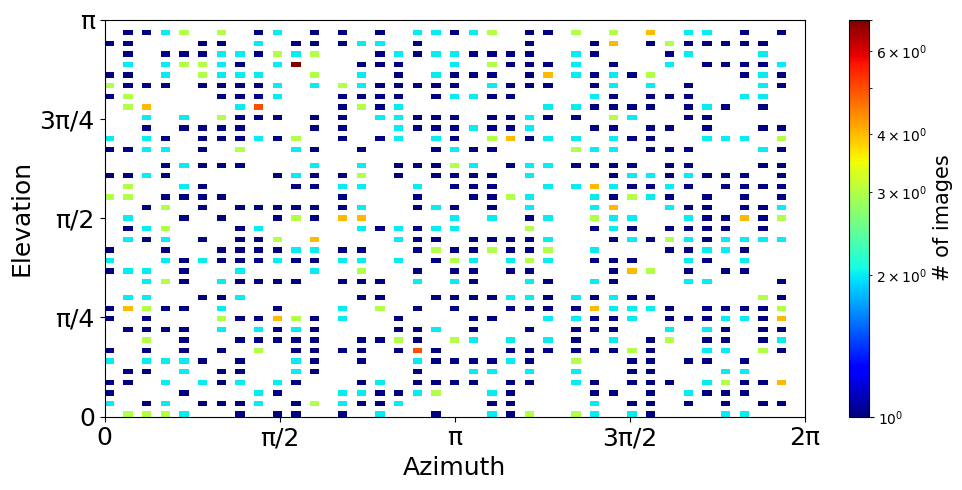

In [7]:
plot_elev_azimuth(phi_train, theta_train)

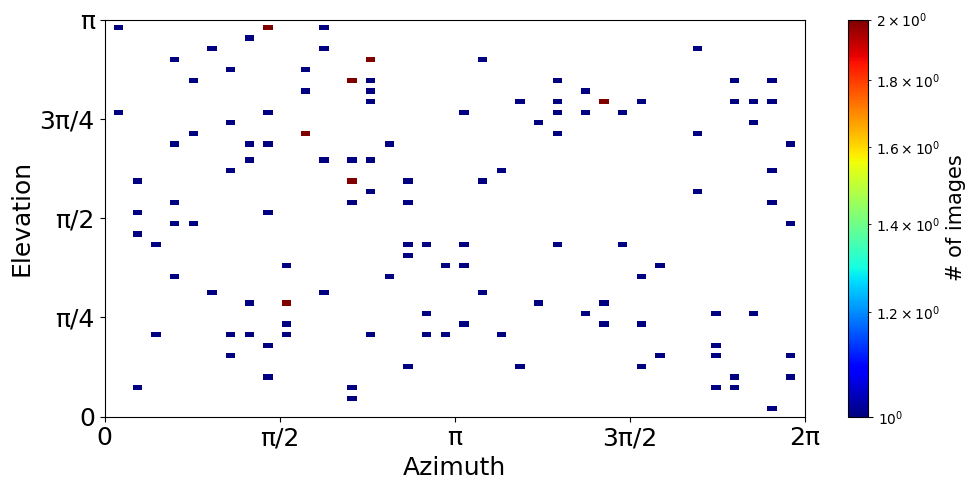

In [8]:
plot_elev_azimuth(phi_test, theta_test)

# Load models

In [9]:
device = "cuda:0"
point_model_dict = torch.load(f'/hpc/projects/group.czii/kithmini.herath/crosspoint-trained-models/results/{exp_name}/models/ckpt_epoch_last.pth', map_location="cuda:0")
img_model_dict = torch.load(f'/hpc/projects/group.czii/kithmini.herath/crosspoint-trained-models/results/{exp_name}/models/img_model_last.pth', map_location="cuda:0")

point_model = DGCNN(args).to(device)
img_model = ResNet(resnet50(), feat_dim = 2048).to(device)

point_model.load_state_dict(point_model_dict)
img_model.load_state_dict(img_model_dict)

<All keys matched successfully>

# Get train/ val features

In [10]:
class saved_data_loader(Dataset):
    def __init__(self, fp = "",pc_transform=None, img_transform = None, type_="train"):
        self.img_data = sorted(glob.glob(f"{fp}/*.npy"))
        self.metadata = pd.read_csv(f"{fp}/metadata.csv")
        
        # print(self.metadata)
        self.img_transform = img_transform
        self.pc_transform = pc_transform
        self.type = type_
        self.label_map = {'ribosome':0, 'neg_class':1}
    
    def __getitem__(self, item):
        img_path = self.img_data[item]
        pc_path = "/".join(img_path.split("/")[:-3])+f"/saved_pointclouds_prenorm_uniqueAnglesSubset_noiseAnalysis/{self.type}/{img_path.split('/')[-1]}"
                
        label_map = {'ribosome':0, 'neg_class':1}

        img = np.load(img_path)[0,0]
        img = self.img_transform(img) 
        
        pc = np.load(pc_path)[0]
        pc = self.pc_transform(pc) 
        
        label = self.metadata[self.metadata['filename'] == img_path.split("/")[-1][:-4]]['label'].iloc[0]
        return pc, img, label, img_path.split("/")[-1][:-4]
    
    def __len__(self):
        return len(self.img_data)

In [11]:
def get_features(pc_model, img_model, loader, device="cuda", type_="train"):
    pc_feats_arr = []
    img_feats_arr = []
    labels_arr = []
    fnames_arr = []
    print(device)
    
    for i, (pcs, imgs, labels, fnames) in enumerate(loader): # fname -- original file name
        pcs = pcs.to(device)
        pcsT = pcs.transpose(2, 1).contiguous()
        imgs = imgs.to(device)
        labels = labels.numpy().tolist()
        fnames = np.array(fnames).tolist()
        
        with torch.no_grad():
            _, _, point_feats = pc_model(pcsT)
            img_feats = img_model.resnet(imgs)
        
        point_feats = F.normalize(point_feats, dim=1).detach().cpu().numpy()
        img_feats = F.normalize(img_feats, dim=1).detach().cpu().numpy()
        pc_feats_arr.extend(point_feats)
        img_feats_arr.extend(img_feats)
        labels_arr += labels
        fnames_arr += fnames
                                
    return np.array(pc_feats_arr), np.array(img_feats_arr), np.array(labels_arr), np.array(fnames_arr)

In [12]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def get_tsne_embeddings(arr):
    # The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
    # out some marginal improvements. NB: This takes almost an hour!
    tsne = TSNE(random_state=0, n_iter=15000, metric="cosine")

    embeddings = tsne.fit_transform(arr)
    return embeddings

def get_pca_embeddings(arr, ncomp=2):
    # Initialize PCA with the number of components you want to keep
    pca = PCA(n_components=ncomp)
    
    # Fit the PCA model and transform the data
    embeddings = pca.fit_transform(arr)
    
    return embeddings

def get_umap_embeddings(arr):
    # Initialize UMAP with the desired number of components
    reducer = umap.UMAP(n_components=2, random_state=42)
    
    # Fit the UMAP model and transform the data
    embeddings = reducer.fit_transform(arr)
    
    return embeddings

# Visualizing point cloud and image embedding space

Neg class label map:
* proteasome = 1
* apoferritin = 2
* betagal = 3

In [13]:
# Vis codes

def get_binary_umap(info, data_type, type_, noise_level):
    df = pd.DataFrame({
        'UMAP1': info[f'{data_type}_feat1'],
        'UMAP2': info[f'{data_type}_feat2'],
        'PDB_ID': info['pdb_ids'],
        'Label': info['labels']
    })

    df = df.drop_duplicates(subset=['PDB_ID'], keep='first')
    df = df.reset_index(drop=True)
    print(df.shape)

    df['Label'] = df['Label'].astype('category')

    color_map = {0: 'orange', 1: 'green'}

    # Create the scatter plot using Plotly
    fig = px.scatter(df, x='UMAP1', y='UMAP2', color='Label',
                     color_discrete_map=color_map,
                     hover_data={'PDB_ID': True},
                     size_max=15)

    # Update legend labels
    fig.for_each_trace(lambda t: t.update(name='Ribosome' if t.name == '0' else 'Neg_class'))

    # fig.update_layout(width=900, height=900, legend_title_text='Class')
    fig.update_layout(width=1200, height=1200,
                      legend_title_text='Class',
                      font=dict(size=35),
                      xaxis=dict(
                      title='UMAP1',
                      tickfont=dict(size=35),
                      autorange=True),
                      yaxis=dict(
                      title='UMAP2',
                      tickfont=dict(size=35),
                      autorange=True),
                      xaxis_title_font_size=35,
                      yaxis_title_font_size=35,
                      # xaxis_tickfont_size=20,
                      # yaxis_tickfont_size=20
                      showlegend=False
                      )
    fig.update_xaxes(title=dict(text="<b>UMAP1</b>", font=dict(size=35)))
    fig.update_yaxes(title=dict(text="<b>UMAP2</b>", font=dict(size=35)))

    fig.update_traces(marker=dict(size=15))

    fig.write_image(f"/hpc/projects/group.czii/kithmini.herath/crosspoint-analysis/first_experiments_multipleclasses_pointmodel_uniqueanglesubsets/{type_}_{data_type}_noise({noise_level})_umap_main.pdf")
    
def get_classwise_umap(info, data_type, type_, noise_level):
    df = pd.DataFrame({
        'UMAP1': info[f'{data_type}_feat1'],
        'UMAP2': info[f'{data_type}_feat2'],
        'PDB_ID': info['pdb_ids'],
        'Label': info['labels']
    })

    df = df.drop_duplicates(subset=['PDB_ID'], keep='first')
    df = df.reset_index(drop=True)
    print(df.shape)

    for l in range(df.shape[0]):
        if "pro" in df.loc[l, 'PDB_ID']:
            df.loc[l, 'Label'] = 1
        elif "fer" in df.loc[l, 'PDB_ID']:
            df.loc[l, 'Label'] = 2
        elif "gal" in df.loc[l, 'PDB_ID']:
            df.loc[l, 'Label'] = 3

    df['Label'] = df['Label'].astype('category')

    color_map = {0: 'orange', 1: 'green', 2: 'red', 3: 'blue'}

    fig = px.scatter(df, x='UMAP1', y='UMAP2', color='Label',
                     color_discrete_map=color_map,
                     hover_data={'PDB_ID': True},
                     size_max=15) # ,title=f'UMAP plot of image features | {type_} | noise_std({noise_level})'

    fig.for_each_trace(lambda t: t.update(name={
        '0': 'Ribosome',
        '1': 'Proteasome',
        '2': 'Apoferritin',
        '3': 'Beta-gal'
    }.get(t.name, 'Unknown')))

    fig.update_layout(width=1200, height=1200,
                      legend_title_text='Class',
                      font=dict(size=35),
                      xaxis=dict(
                      title='UMAP1',
                      tickfont=dict(size=35),
                      autorange=True),
                      yaxis=dict(
                      title='UMAP2',
                      tickfont=dict(size=35),
                      autorange=True),
                      xaxis_title_font_size=35,
                      yaxis_title_font_size=35,
                      # xaxis_tickfont_size=20,
                      # yaxis_tickfont_size=20
                      showlegend=False
                      )
    fig.update_xaxes(title=dict(text="<b>UMAP1</b>", font=dict(size=35)))
    fig.update_yaxes(title=dict(text="<b>UMAP2</b>", font=dict(size=35)))

    fig.update_traces(marker=dict(size=15))

    pio.write_image(fig, f"/hpc/projects/group.czii/kithmini.herath/crosspoint-analysis/first_experiments_multipleclasses_pointmodel_uniqueanglesubsets/{type_}_{data_type}_noise({noise_level})_clswise_umap_main.pdf", width=1200, height=1200)

In [14]:
noise_2d = [0.0, 0.01, 0.03, 0.05]

data_dir = "/hpc/projects/group.czii/kithmini.herath/contrastive-learning-data/new_data/saved_projections_prenorm_uniqueAnglesSubset_noiseAnalysis"
exp_name = "crosspoint_newFSData_simclr_noNorm_noise2d_0_0.01_0.03_0.05"
label_map = {0:'ribosome',1:'neg_class'}

img_model = img_model.to(device)
img_model = img_model.eval()

point_model = point_model.to(device)
point_model = point_model.eval()

for noise in noise_2d:
    print(f"Noise level = {noise} *************************")
    transform = transforms.Compose([transforms.ToTensor(),
                                    d_utils.AddGaussianNoise(std=noise, p=1),
                                    # transforms.Resize((224, 224), antialias=True),
                                    # transforms.Normalize((0.5,), (0.5,))
                                   ])
    
    pc_trans = transforms.Compose([d_utils.PointcloudToTensor()]) 

    type_ = "train"
    train_set = saved_data_loader(f"{data_dir}/{type_}", pc_transform=pc_trans, img_transform = transform, type_=type_)
    train_loader = DataLoader(train_set, num_workers=12, batch_size=32, shuffle=True, drop_last=True, pin_memory=True) # the n_imgs parameter is not being used as of now

    type_ = "test"
    val_set = saved_data_loader(f"{data_dir}/{type_}", pc_transform=pc_trans, img_transform = transform, type_=type_)
    val_loader = DataLoader(val_set, num_workers=12, batch_size=32, shuffle=True, drop_last=True, pin_memory=True)

    ########## Feature Extraction
    # normalized features
    point_feats_train, img_feats_train, labels_train, fnames_train = get_features(point_model, img_model, train_loader, device=device, type_="train")
    print(f"PC features (train) shape: {point_feats_train.shape} | Image features (train) shape: {img_feats_train.shape}")
    print(img_feats_train.shape, labels_train.shape, fnames_train.shape)
    print(labels_train, len(labels_train))

    # normalized features
    point_feats_val, img_feats_val, labels_val, fnames_val = get_features(point_model, img_model, val_loader, device=device, type_="val")
    print(f"PC features (test) shape: {point_feats_val.shape} | Image features (test) shape: {img_feats_val.shape}")
    print(point_feats_val.shape, img_feats_val.shape, labels_val.shape, fnames_val.shape)
    print(labels_val, len(labels_val))
    
    ########## Get 2D embeddings for umap/ pca
    # img_feats_train_embs = get_pca_embeddings(img_feats_train,2)
    # img_feats_val_embs = get_pca_embeddings(img_feats_val,2)

    point_feats_train_embs = get_umap_embeddings(point_feats_train)
    point_feats_val_embs = get_umap_embeddings(point_feats_val)
    img_feats_train_embs = get_umap_embeddings(img_feats_train)
    img_feats_val_embs = get_umap_embeddings(img_feats_val)

    train_point_dict = {
        "point_feat1": point_feats_train_embs[:,0],
        "point_feat2": point_feats_train_embs[:,1],
        "labels": [label_map[label] for label in labels_train]
    }

    val_point_dict = {
        "point_feat1": point_feats_val_embs[:,0],
        "point_feat2": point_feats_val_embs[:,1],
        "labels": [label_map[label] for label in labels_val]
    }
    
    train_img_dict = {
        "img_feat1": img_feats_train_embs[:,0],
        "img_feat2": img_feats_train_embs[:,1],
        "labels": [label_map[label] for label in labels_train]
    }

    val_img_dict = {
        "img_feat1": img_feats_val_embs[:,0],
        "img_feat2": img_feats_val_embs[:,1],
        "labels": [label_map[label] for label in labels_val]
    }

    
    info_point_train = {
        "point_feat1": point_feats_train_embs[:,0],
        "point_feat2": point_feats_train_embs[:,1],
        "labels": labels_train,
        "pdb_ids": fnames_train
    }

    info_point_val = {
        "point_feat1": point_feats_val_embs[:,0],
        "point_feat2": point_feats_val_embs[:,1],
        "labels": labels_val,
        "pdb_ids": fnames_val
    }
    
    info_img_train = {
        "img_feat1": img_feats_train_embs[:,0],
        "img_feat2": img_feats_train_embs[:,1],
        "labels": labels_train,
        "pdb_ids": fnames_train
    }

    info_img_val = {
        "img_feat1": img_feats_val_embs[:,0],
        "img_feat2": img_feats_val_embs[:,1],
        "labels": labels_val,
        "pdb_ids": fnames_val
    }

    ########## Visualize embedding space
    get_binary_umap(info_point_train, "point", "train", noise)
    get_classwise_umap(info_point_train, "point", "train", noise)
    
    get_binary_umap(info_point_val, "point", "test", noise)
    get_classwise_umap(info_point_val, "point", "test", noise)
    
    get_binary_umap(info_img_train, "img", "train", noise)
    get_classwise_umap(info_img_train, "img", "train", noise)
    
    get_binary_umap(info_img_val, "img", "test", noise)
    get_classwise_umap(info_img_val, "img", "test", noise)

Noise level = 0.0 *************************
cuda:0
PC features (train) shape: (1248, 2048) | Image features (train) shape: (1248, 2048)
(1248, 2048) (1248,) (1248,)
[0 0 0 ... 1 0 1] 1248
cuda:0
PC features (test) shape: (128, 2048) | Image features (test) shape: (128, 2048)
(128, 2048) (128, 2048) (128,) (128,)
[0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1
 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1
 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0
 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 1 1] 128


/hpc/mydata/kithmini.herath/anaconda/latest/x86_64/envs/crosspoint_2dtm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/hpc/mydata/kithmini.herath/anaconda/latest/x86_64/envs/crosspoint_2dtm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/hpc/mydata/kithmini.herath/anaconda/latest/x86_64/envs/crosspoint_2dtm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/hpc/mydata/kithmini.h

(1248, 4)
(1248, 4)
(128, 4)
(128, 4)
(1248, 4)
(1248, 4)
(128, 4)
(128, 4)
Noise level = 0.01 *************************
cuda:0
PC features (train) shape: (1248, 2048) | Image features (train) shape: (1248, 2048)
(1248, 2048) (1248,) (1248,)
[0 0 0 ... 1 1 0] 1248
cuda:0
PC features (test) shape: (128, 2048) | Image features (test) shape: (128, 2048)
(128, 2048) (128, 2048) (128,) (128,)
[0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 1
 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1
 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0] 128


/hpc/mydata/kithmini.herath/anaconda/latest/x86_64/envs/crosspoint_2dtm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/hpc/mydata/kithmini.herath/anaconda/latest/x86_64/envs/crosspoint_2dtm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/hpc/mydata/kithmini.herath/anaconda/latest/x86_64/envs/crosspoint_2dtm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/hpc/mydata/kithmini.herath/anaconda/latest/x86_64/envs/crosspoint_2dtm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



(1248, 4)
(1248, 4)
(128, 4)
(128, 4)
(1248, 4)
(1248, 4)
(128, 4)
(128, 4)
Noise level = 0.03 *************************
cuda:0
PC features (train) shape: (1248, 2048) | Image features (train) shape: (1248, 2048)
(1248, 2048) (1248,) (1248,)
[1 0 1 ... 1 0 0] 1248
cuda:0
PC features (test) shape: (128, 2048) | Image features (test) shape: (128, 2048)
(128, 2048) (128, 2048) (128,) (128,)
[0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0
 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1
 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0
 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0] 128


/hpc/mydata/kithmini.herath/anaconda/latest/x86_64/envs/crosspoint_2dtm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/hpc/mydata/kithmini.herath/anaconda/latest/x86_64/envs/crosspoint_2dtm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/hpc/mydata/kithmini.herath/anaconda/latest/x86_64/envs/crosspoint_2dtm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/hpc/mydata/kithmini.herath/anaconda/latest/x86_64/envs/crosspoint_2dtm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



(1248, 4)
(1248, 4)
(128, 4)
(128, 4)
(1248, 4)
(1248, 4)
(128, 4)
(128, 4)
Noise level = 0.05 *************************
cuda:0
PC features (train) shape: (1248, 2048) | Image features (train) shape: (1248, 2048)
(1248, 2048) (1248,) (1248,)
[1 1 0 ... 0 1 1] 1248
cuda:0
PC features (test) shape: (128, 2048) | Image features (test) shape: (128, 2048)
(128, 2048) (128, 2048) (128,) (128,)
[1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0
 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0
 0 0 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1
 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0] 128


/hpc/mydata/kithmini.herath/anaconda/latest/x86_64/envs/crosspoint_2dtm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/hpc/mydata/kithmini.herath/anaconda/latest/x86_64/envs/crosspoint_2dtm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/hpc/mydata/kithmini.herath/anaconda/latest/x86_64/envs/crosspoint_2dtm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/hpc/mydata/kithmini.herath/anaconda/latest/x86_64/envs/crosspoint_2dtm/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



(1248, 4)
(1248, 4)
(128, 4)
(128, 4)
(1248, 4)
(1248, 4)
(128, 4)
(128, 4)
